[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


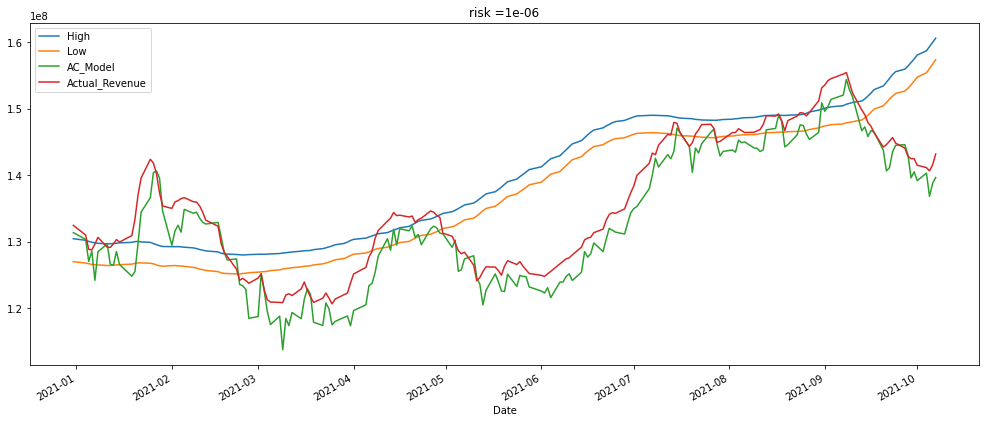

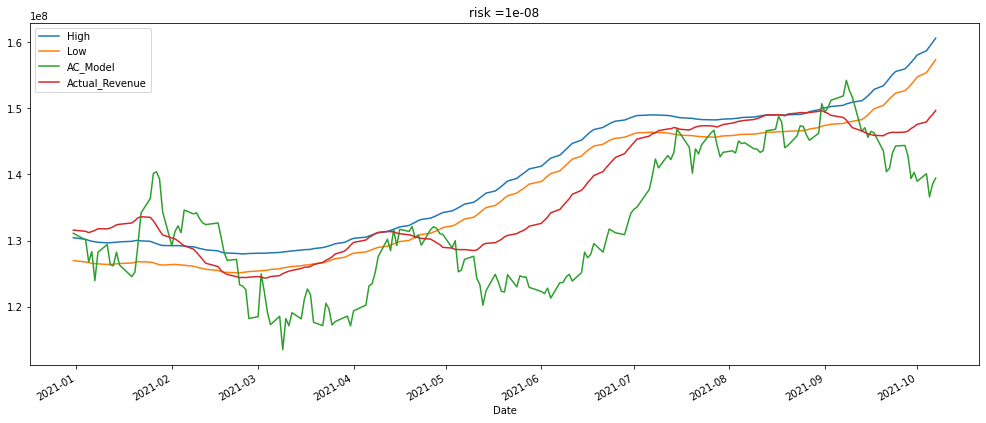

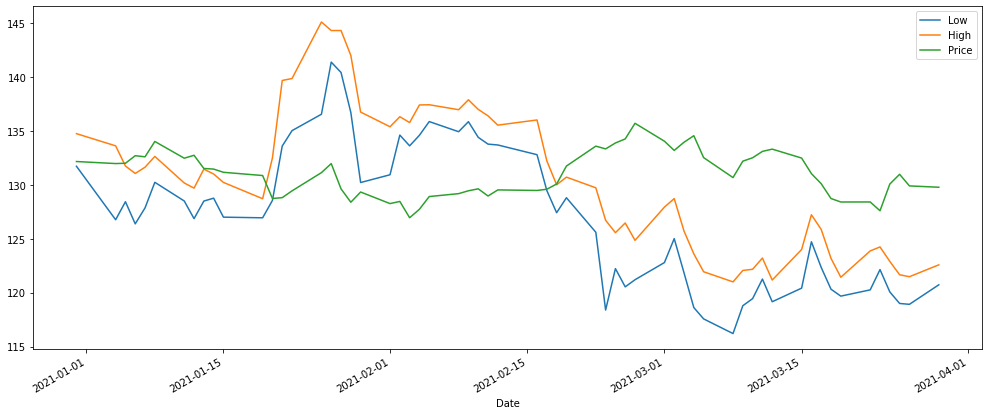

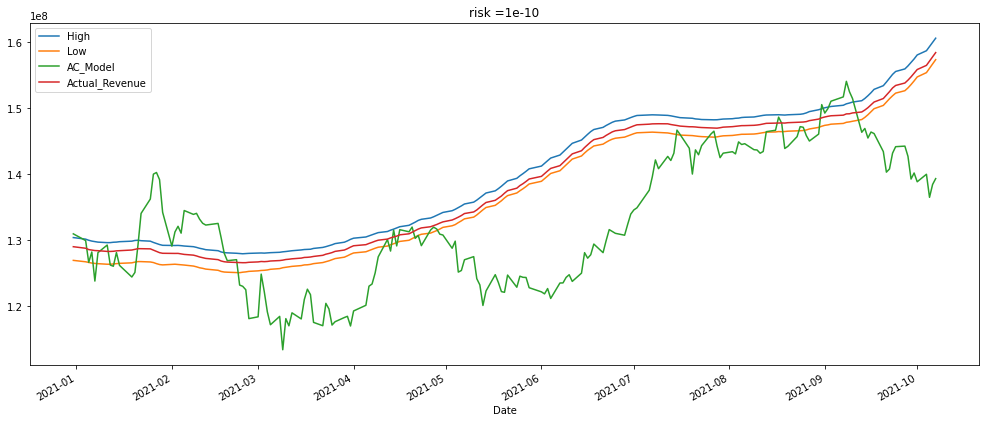

In [3]:
import pandas as pd
import copy
import syntheticChrissAlmgren2 as sca
import utils
import numpy as np
import yfinance as yf
import time
import sys
import matplotlib.pyplot as plt
from datetime import date, timedelta



class AC_model():
    def __init__(self, TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ticker, ANNUAL_VOLAT, BID_ASK_SP, llambda_list):
        
        self.TOTAL_SHARES = TOTAL_SHARES
        self.NUM_TRADES = NUM_TRADES
        self.LIQUIDATION_TIME = LIQUIDATION_TIME
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker

        self.subtract_days = timedelta(NUM_TRADES)
        self.num_shares, self.last_num_shares = self.round_num_shares(self.TOTAL_SHARES, self.NUM_TRADES)
        self.data_origin =yf.download(ticker, start=start_date, end=end_date)
        self.TRAD_DAYS = len(self.data_origin['Open'])
        self.slidingwindow_num = self.TRAD_DAYS - NUM_TRADES + 1
        self.randomseed = 0                                
        self.BID_ASK_SP = BID_ASK_SP
        self.tau = 1
        self.DAILY_VOLAT = ANNUAL_VOLAT / np.sqrt(self.TRAD_DAYS)
        self.index_list = self.data_origin.index[:]
        self.llambda_list= llambda_list
        

        self.df = yf.download(ticker, start = start_date-timedelta(252), end = end_date)
        self.df_trad = self.df.tail(self.TRAD_DAYS)
        self.total_cash_list, self.date_list = self.calculate_revenue(self.df_trad, 'High', self.slidingwindow_num, 
                                                       self.NUM_TRADES, self.num_shares, self.last_num_shares)
        self.frame1 = pd.DataFrame({"Date": self.date_list, "High": self.total_cash_list})

        self.total_cash_list2, self.date_list2 = self.calculate_revenue(self.df_trad, 'Low', self.slidingwindow_num, 
                                                       self.NUM_TRADES, self.num_shares, self.last_num_shares)
        self.frame2 = pd.DataFrame({"Date": self.date_list2, "Low": self.total_cash_list2})


    def round_num_shares(self, total_shares, num_trades):
        num_shares = total_shares // num_trades + 1
        last_num_shares = num_shares
        if type(total_shares / num_trades) != int:
            last_num_shares = total_shares - (num_shares*(num_trades-1))

        return num_shares, last_num_shares

    def calculate_revenue(self, df, category, slidingwindow_num, NUM_TRADES, num_shares, last_num_shares):
        total_cash_list = []
        date_list = []
        for window_num in range(slidingwindow_num):
            total_cash = 0
            for idx in range(NUM_TRADES):
                price = df[category][window_num:window_num+NUM_TRADES][idx]
                if idx == NUM_TRADES:
                    daily_cash = price * last_num_shares
                else:
                    daily_cash = price * num_shares
                total_cash += daily_cash
            total_cash_list.append(int(total_cash))
            date_list.append(df[category].index[window_num])

        return total_cash_list, date_list
    
    
    def simulate_ac_model(self):
        for risk in self.llambda_list:
            llambda = risk
            cnt = 0
            start = -abs(self.TRAD_DAYS+self.LIQUIDATION_TIME)
            end = -abs(self.TRAD_DAYS)
            ac_date_list =[]
            Actual_Revenue_List = []
            
            capture_list = []

            for idx in range(self.slidingwindow_num):

                data = self.df.iloc[start:end]
                if end+NUM_TRADES != 0:
                    data_real_price = self.data_origin.iloc[end:end+self.NUM_TRADES]['Open'].to_numpy()
                else:
                    data_real_price = self.data_origin.iloc[end:]['Open'].to_numpy()

                today = self.df.index[end]
                ac_date_list.append(today)

                average_daily_volume = np.mean(data['Volume'])
                average_daily_spread = np.mean(data['High'] - data['Low'])

                sigma = np.std(data['Close'])
                epsilon = average_daily_spread/2
                eta = average_daily_spread/(0.01*average_daily_volume)
                gamma = average_daily_spread/(0.1*average_daily_volume)

                env = sca.MarketEnvironment()
                env.__init__(randomSeed=0,
                             lqd_time = self.LIQUIDATION_TIME,
                             num_tr = self.NUM_TRADES,
                             lambd =llambda)

                # Initialize the Almgren-Chriss parameters so we can access them later
                env.total_shares = self.TOTAL_SHARES
                env.startingPrice = data.tail(1)['Close'][0]

                env.epsilon = epsilon
                env.singleStepVariance = (self.DAILY_VOLAT  * env.startingPrice) ** 2
                env.eta = eta
                env.gamma = gamma

                # Calculate some Almgren-Chriss parameters
                env.tau = self.tau
                env.eta_hat = env.eta - (0.5 * env.gamma * env.tau)
                env.kappa_hat = np.sqrt((env.llambda * env.singleStepVariance) / env.eta_hat)
                env.kappa = np.arccosh((((env.kappa_hat ** 2) * (env.tau ** 2)) / 2) + 1) / env.tau

                # Set the variables for the initial state
                env.shares_remaining = env.total_shares
                env.timeHorizon = env.num_n

                # Set the initial impacted price to the starting price
                env.prevImpactedPrice = env.startingPrice

                # Set the initial transaction state to False
                env.transacting = False

                # Set a variable to keep trak of the trade number
                env.k = 0

                # Get the trading list from the environment
                trl = env.get_trade_list()

                # Since we are not selling fractional shares we round up the shares in the trading list
                trade_list = utils.round_trade_list(trl)

                # set the environment to make transactions
                env.start_transactions()
                # Create an array to hold the impacted stock price
                price_hist = np.array([])

                # Implement the trading list in our similation environment
                for trade in trade_list:

                    # Convert the number of shares to sell in each trade into an action
                    action = trade / env.shares_remaining

                    # Take a step in the environment my selling the number of shares in the current trade
                    _, _, _, info = env.step(action)

                    # Get the impacted price from the environment
                    price_hist = np.append(price_hist, info.exec_price)
                    if info.done:
                        capture = info.totalCapture
                        
                    # If all shares have been sold, stop making transactions and get the implementation sortfall
                    if info.done:
                        #print('Implementation Shortfall: ${:,.2f} \n'.format(info.implementation_shortfall))
                        break


                final_trade_list = np.trim_zeros(trade_list.astype(int))
                capture_list.append(int(capture))

                if len(final_trade_list) != len(data_real_price):
                    length = len(final_trade_list)
                    modified_data_real_price = data_real_price[:length]
                else:
                    modified_data_real_price = data_real_price

                Actual_Revenue_append = int(np.sum(final_trade_list*modified_data_real_price))
                Actual_Revenue_List.append(Actual_Revenue_append)

                start += 1
                end += 1

                if llambda == 1e-10 and idx == 0:
                    price_list_num = len(price_hist)
                    
                    GBM_price_frame = pd.DataFrame({"Date":self.index_list[:price_list_num], "Price": price_hist})
                    GBM_price_frame.set_index("Date", inplace = True)
                    REAL_LOW_price_frame = self.data_origin['Low'].head(price_list_num)
                    
                    REAL_HIGH_price_frame = self.data_origin['High'].head(price_list_num)
                    realFrame = pd.merge(REAL_LOW_price_frame, REAL_HIGH_price_frame,left_index=True, right_index=True)
                    finalFrame = pd.merge(realFrame,GBM_price_frame, left_index=True, right_index=True)
                    finalFrame.plot()



            ACframe = pd.DataFrame({"Date": ac_date_list, "AC_Model":capture_list})
            ARframe = pd.DataFrame({"Date": ac_date_list, "Actual_Revenue": Actual_Revenue_List})
            newframe = pd.merge(self.frame1, self.frame2, how='inner', on='Date').merge(ACframe, on = 'Date').merge(ARframe, on='Date')
            newframe.set_index("Date", inplace=True)

            plt.rcParams['figure.figsize'] = [17.0, 7.0]
            titleName = "risk =" + str(llambda)
            newframe.plot(title = titleName)


TOTAL_SHARES = 1000000
NUM_TRADES = 60
LIQUIDATION_TIME = 60
start_date = date(2021,1,1)
end_date = '2022-01-01'
ticker = 'AAPL'
ANNUAL_VOLAT = 0.12                                
BID_ASK_SP = 1 / 8                                                                 
llambda_list= [1e-06, 1e-08 ,1e-10]
plt.rcParams['figure.figsize'] = [17.0, 7.0]

simulation = AC_model(TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ticker, ANNUAL_VOLAT, BID_ASK_SP, llambda_list)
simulation.simulate_ac_model()

